**License**

MIT License

Copyright (c) 2021 jphall@gwu.edu;
Copyright (c) 2024 owandalowski@gwu.edu, jmillietsciorra@gwmail.gwu.edu, mehakpreet.kaur@gwmail.gwu.edu, jiwon78@gwmail.gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Python Imports


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

# Version Information

In [3]:
# print version information
import sys
import sklearn
version = ".".join(map(str, sys.version_info[:3]))
print('Python version:', version)
print('sklearn version:', sklearn.__version__)

Python version: 3.10.12
sklearn version: 1.5.2


# Upload Data

In [4]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

# Pre Processing

In [5]:
# Fill missing values for 'Age' with the median
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

# Fill missing values for 'Embarked' with the mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

# Convert 'Sex' and 'Embarked' columns to numeric using one-hot encoding
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked'], drop_first=True)

# Drop irrelevant columns in the training data
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Hold PassengerId column temporarily to use later in the eventual predictions dataframe
passenger_ids = test_data['PassengerId']

# Drop irrelevant columns in the test data
test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Fill null values with 0
test_data.fillna(0, inplace=True)

<ipython-input-5-78c6e2423ea1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
<ipython-input-5-78c6e2423ea1>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [6]:
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


In [7]:
test_data.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,True,True,False
1,3,47.0,1,0,7.0000,False,False,True
2,2,62.0,0,0,9.6875,True,True,False
3,3,27.0,0,0,8.6625,True,False,True
4,3,22.0,1,1,12.2875,False,False,True


# Basic Data Analysis

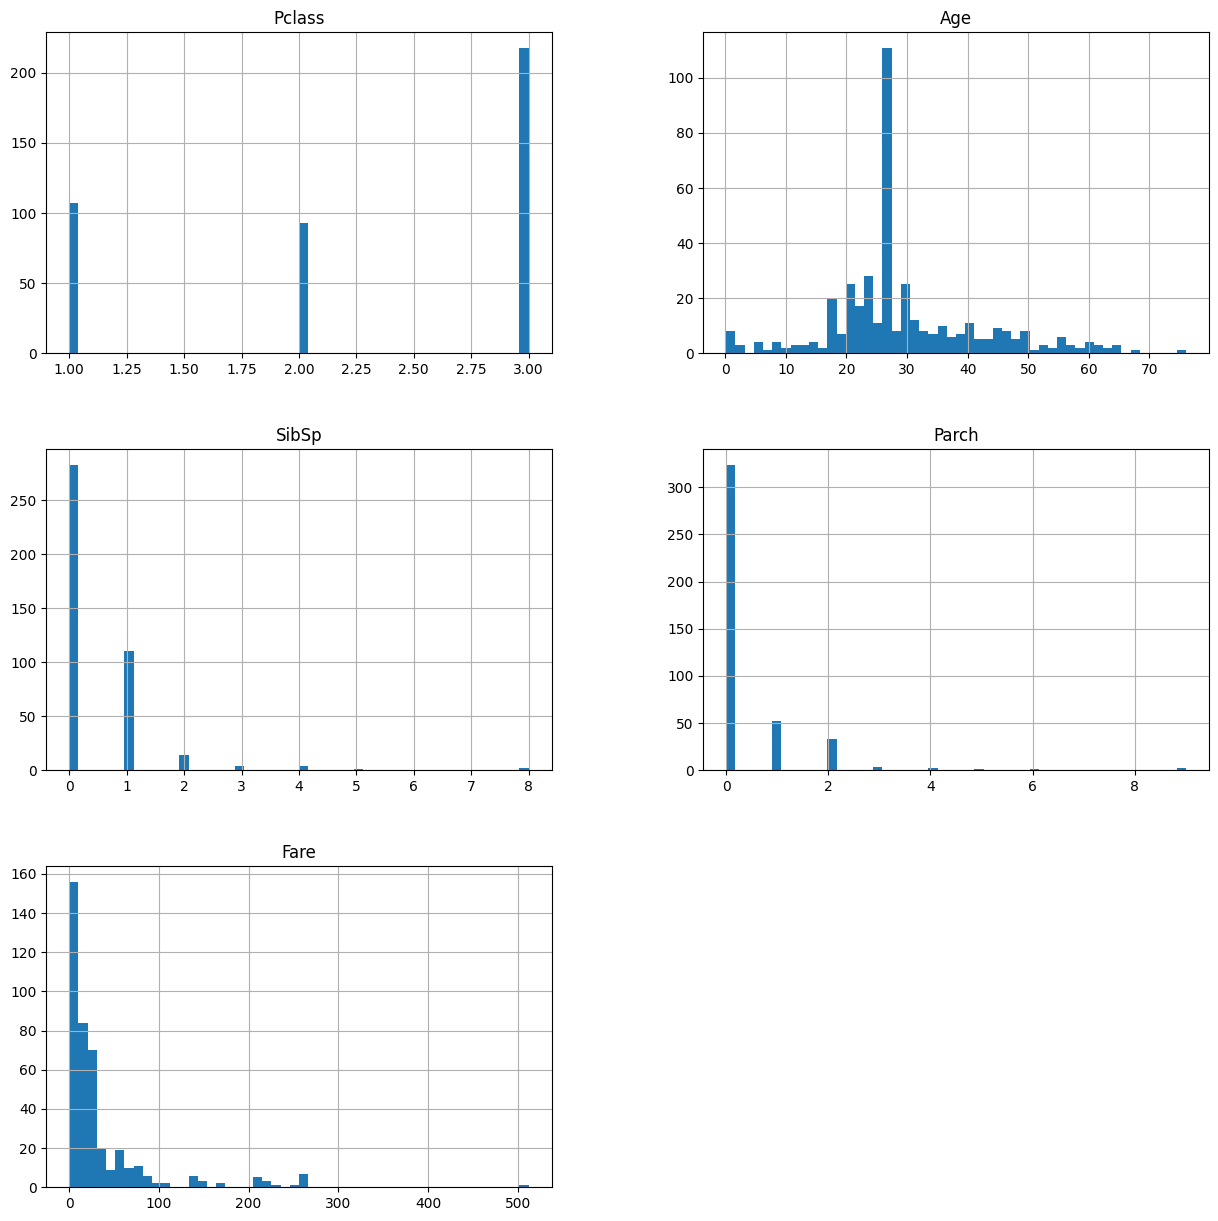

In [8]:
_ = test_data[test_data.columns].hist(bins=50, figsize=(15, 15)) # display histograms

In [9]:
# Pearson correlation matrix
corr = test_data.corr()
corr

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
Pclass,1.000000,-0.467853,0.001087,0.018721,-0.577673,0.108615,0.252608,0.120783
Age,-0.467853,1.000000,-0.071197,-0.043731,0.340740,-0.008035,-0.041310,-0.118594
SibSp,0.001087,-0.071197,1.000000,0.306895,0.172167,-0.099943,-0.098824,0.079367
Parch,0.018721,-0.043731,0.306895,1.000000,0.230501,-0.159120,-0.132948,0.092201
Fare,-0.577673,0.340740,0.172167,0.230501,1.000000,-0.192444,-0.154926,-0.179508
Sex_male,0.108615,-0.008035,-0.099943,-0.159120,-0.192444,1.000000,-0.115574,0.105883
Embarked_Q,0.252608,-0.041310,-0.098824,-0.132948,-0.154926,-0.115574,1.000000,-0.474962
Embarked_S,0.120783,-0.118594,0.079367,0.092201,-0.179508,0.105883,-0.474962,1.000000


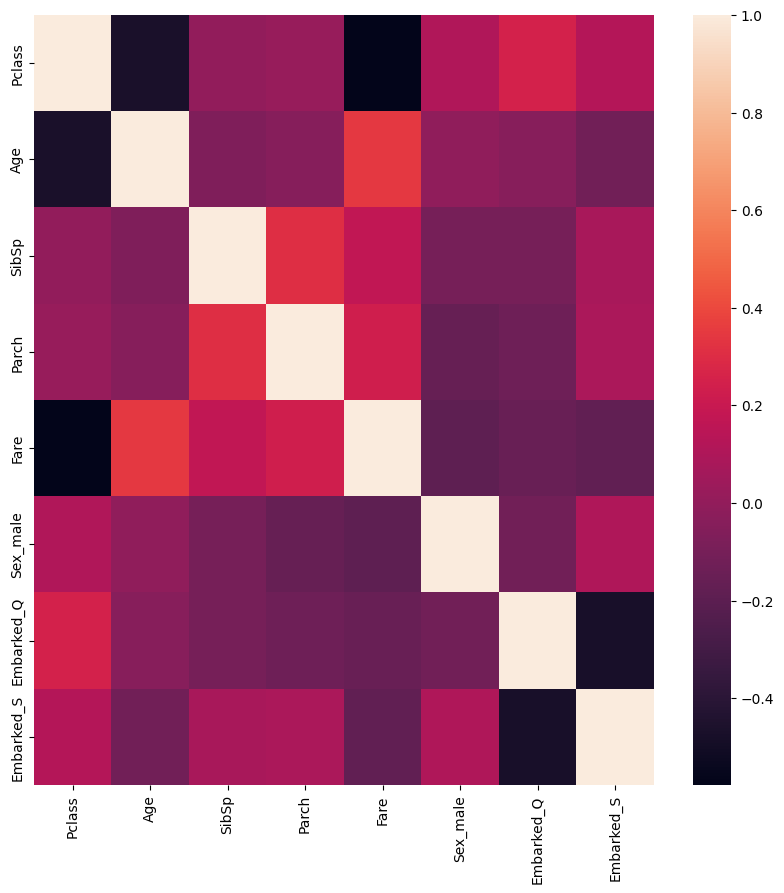

In [10]:
# correlation heatmap
plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

# Train Logistic Regression Model

In [101]:
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

# Split the training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train Logistic Regression Model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_split, y_train_split)

# Evaluate the model on the training data
y_train_pred = logreg.predict(X_train_split)
print("Training Accuracy:", accuracy_score(y_train_split, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train_split, y_train_pred))
print("Classification Report:\n", classification_report(y_train_split, y_train_pred))

# Validate the model
y_val_pred = logreg.predict(X_val)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Test the model on the test dataset (if labels for 'Survived' are available in test set)
if 'Survived' in test_data.columns:
    X_test = test_data.drop('Survived', axis=1)
    y_test = test_data['Survived']
    y_test_pred = logreg.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("Classification Report:\n", classification_report(y_test, y_test_pred))
else:
    # Predict survival for the test dataset (no ground truth)
    predictions = logreg.predict(test_data)
    # Add predictions as a new column to the test dataset
    test_data['Survived'] = predictions
    # Add PassengerID column back into test data
    test_data['PassengerId'] = passenger_ids



Training Accuracy: 0.800561797752809
Confusion Matrix:
 [[385  59]
 [ 83 185]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       444
           1       0.76      0.69      0.72       268

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.78       712
weighted avg       0.80      0.80      0.80       712

Validation Accuracy: 0.8100558659217877
Confusion Matrix:
 [[90 15]
 [19 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



# Predictions

In [102]:
# Create dataframe showing the Passenger ID and their respective survival prediction
predictions = test_data[['PassengerId', 'Survived']]

# Make df a csv file
predictions.to_csv("predictions.csv", index=False)

# AUC for Training and Validation Data

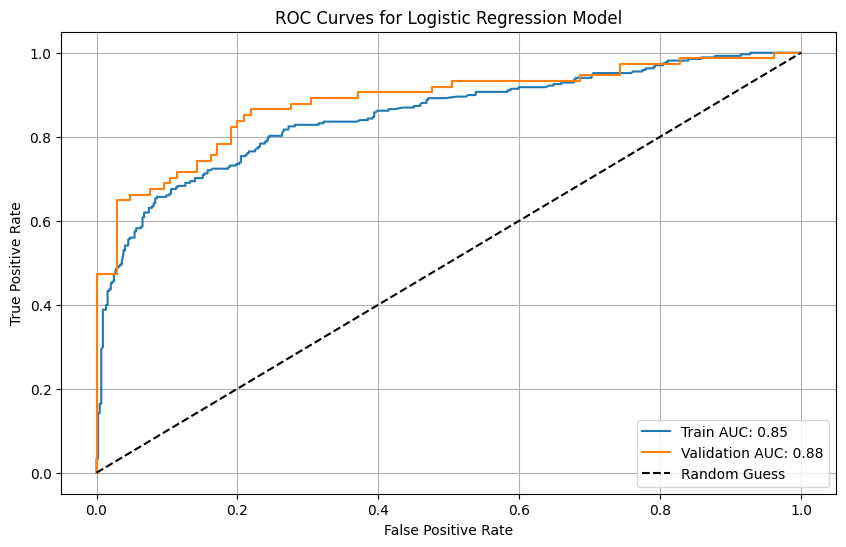

In [74]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate AUC for training, validation, and test data (if labels are available for test)
# Training data
y_train_pred_proba = logreg.predict_proba(X_train_split)[:, 1]
train_auc = roc_auc_score(y_train_split, y_train_pred_proba)

# Validation data
y_val_pred_proba = logreg.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred_proba)

# Create ROC curves
plt.figure(figsize=(10, 6))

# ROC for training data
train_fpr, train_tpr, _ = roc_curve(y_train_split, y_train_pred_proba)
plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc:.2f}")

# ROC for validation data
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.plot(val_fpr, val_tpr, label=f"Validation AUC: {val_auc:.2f}")

# ROC for test data (if available)
#if test_auc is not None:
#    test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_proba)
#    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc:.2f}")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves for Logistic Regression Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Display metrics in a structured format
metrics_summary = {
    "Dataset": ["Train", "Validation"],
    "AUC": [train_auc, val_auc]
}
metrics_df = pd.DataFrame(metrics_summary)